In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [2]:
import pickle
import json

In [3]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [4]:
def plot_group(*args, s = 7):
    n = len(args) // 2
    
    plt.figure(figsize=(s,s))
    f, a = plt.subplots(1, n,figsize=(s,s))
    #f.set_figsize((s,s))
    for i in range(n):
        im = args[2*i]
        if args[2*i + 1]:
            im = np.log(im + 1)
        a[i].imshow(im)

    plt.show()

In [5]:
from nltk import ngrams

In [6]:
def single_amplify(to_amplify, population=None, v = False):
    if population is None:
        population = [x for x in to_amplify]
    
    new = []
    for chain in to_amplify:
        if chain[0] == 0:

            start = np.random.randint(1, len(chain) - 1)
            stop = False
            end = np.random.randint(start + 1, len(chain))

            new_chain = [0]
            pointer = start

            while not stop:
                switch = np.random.rand() < SWITCH_PROB

                if v:
                    print(chain, new_chain, switch)
                if switch:
                    new_chain[0] = 1
                    chain = population[np.random.randint(0, len(population))]
                    pointer = np.random.randint(1, len(chain))

                if np.random.rand() < STOP_PROB:
                    stop = True

                if len(new_chain) >= end - start:
                    stop = True

                if pointer < len(chain):
                    new_chain.append(chain[pointer])
                else:
                    stop = True

                pointer += 1 

            if len(new_chain) > 2:
                new.append(new_chain)
    
    return [[x[0]] + x[:0:-1] for x in new]

In [7]:
def PCR_cycle(population_f, population_b):
#     mask_f = np.random.binomial(1, AMPLIFY_PROB, len(population_f))
#     mask_b = np.random.binomial(1, AMPLIFY_PROB, len(population_b))
    mask_f = np.ones(len(population_f))
    mask_b = np.ones(len(population_b))
    
    to_amp_f = np.array(population_f)[mask_f.astype(bool)]
    to_amp_b = np.array(population_b)[mask_b.astype(bool)]
    
    new_f = single_amplify(to_amp_b, population_b)
    new_b = single_amplify(to_amp_f, population_f)
    
    population_f.extend([x for x in new_f if len(x) > 1])
    population_b.extend([x for x in new_b if len(x) > 1])

#    new_f = [x[::-1] for x in single_amplify(to_amp_f, population_f)]
#    population_f.extend([x for x in new_f if len(x) > 1])
            
    #population.extend([x for x in new if len(x) > 1])

In [8]:
def generate_elka_graph(spacers_num):
    graph = np.zeros((spacers_num, spacers_num))
    for i in range(spacers_num):
        for j in range(spacers_num -1, i, -1):
            graph[i,j] = spacers_num - j
    return graph

def generate_shift_diag_graph(spacers_num):
    graph = np.zeros((spacers_num, spacers_num))
    for i in range(spacers_num -1):
        graph[i, i + 1] = 1
    return graph

In [9]:
def generate_initial_population(graph, chain_number=2, max_amount_per_chain = 2, min_len = 4, max_len = 10, v = False):
    # markov is our god! 
    spacers_num = graph.shape[0]
   

    if v:
        plot_gr(graph)
        
    graph /= np.max(np.vstack((graph.sum(1), np.ones(spacers_num))), 0).reshape(-1,1)
    all_chains = []
    while len(all_chains) < chain_number:
        chain = []
        amount = np.random.randint(1, max_amount_per_chain)
        max_chain_len = max([np.random.randint(min_len, max_len) for i in range(3)])
        curr = np.random.randint(0, (spacers_num - 1) / 2 )

        for j in range(max_chain_len):
            chain.append(curr)
            if curr != spacers_num - 1:
                #print(np.arange(spacers_num), graph[curr])
                curr = np.random.choice(np.arange(spacers_num), 1, p = graph[curr])[0]
            else:
                break
        
        if len(chain) > min_len:
            all_chains.extend([chain for k in range(amount)])
    
    return all_chains[:chain_number]

In [16]:
def generate_tree_population(n_spacers, min_len, max_len = 15, v = False):
    chain = np.arange(n_spacers)
    
    l1 = np.random.randint(3, max_len)
    last = l1
    
    p = []
    for reps in  range(np.random.randint(1,5)):
        p.append([x for x in range(l1)])
    #p.append([x for x in range(l1)] * np.random.randint(1,5))
    
    required_pop_n = np.random.randint(5, 20)
    
    while len(p) < required_pop_n:
        if v :
            print(p)
            print(last)
        if np.random.rand() < 0.7:
            new_last = np.random.randint(last, min(n_spacers, last + max_len))
            
            c = [x for x in range(last, new_last)]
            #last = new_last
        else:
            c_start = p[np.random.randint(0, len(p))]
            #c = [x for x in c_start[:np.random.randint(1,len(c_start))]]
            c = [x for x in c_start[:np.random.randint(0,len(c_start) - 1):np.random.randint(1,len(c_start))]]
            
            new_last = np.random.randint(last, min(n_spacers, last + max_len - len(c)))
            for x in range(last, new_last):
                c.append(x)
            
            
        
        if len(c) > min_len:
            for reps in  range(np.random.randint(1,5)):
                p.append(c)
            last = new_last
    
    
    
#     p_ = []
#     for c in p:
#         p_.append( + c)
    return p

In [14]:
pp = generate_tree_population(35, 4)

In [66]:
def generate_primers(n, types = [0,1,2,3]):
    pl = []
    splits = [0] + sorted(np.round(np.random.rand(len(types) - 1) * n).astype(int)) + [n]
    
    #print(splits)
    for i, (a,b) in enumerate(zip(splits, splits[1:])):
        pl.extend([[types[i]]] * (b-a))
        
    return pl

In [92]:
def add_repeats(p, max_primers = 400):
    p_ = []
    for a in p:
        a_ = [-2, -2]
        
        for c in a:
            a_.append(np.random.randint(0,2))
            a_.append(c)
        a_.append(np.random.randint(0,2))
        a_.extend([-2,-2])
        
        p_.append(a_)
    
    pf = [x for x in p_]
    pb = [x for x in p_]
    
    pf.extend(generate_primers(max_primers))
    pb.extend(generate_primers(max_primers))
    
    return pf, pb
    

In [93]:
generate_primers(10)

[[1], [2], [2], [2], [3], [3], [3], [3], [3], [3]]

In [76]:
class Population:
    def _from_ip(
                 initial_population, 
                 primers_counts,
                 max_len = 10):
        max_len = max_len
        max_size = (sum(primers_counts.values()) + len(initial_population))
        
        p = np.ones((max_size, max_len)).astype(int) * -1
        
        pos = 0
        for arr in initial_population:
            j_pos = (max_len - len(arr)) // 2 + ((max_len - len(arr)) // 2) % 2
            p[pos, j_pos: j_pos + len(arr)] = arr
            pos += 1
        for k, v in primers_counts.items():
            j_pos = max_len  // 2 - (max_len // 2) % 2
            p[pos: pos + v, j_pos ] = k
            pos += v
        
        return Population(p)
    
    def __init__(self, p):
        self.p = p
        self.max_len = p.shape[1]
        self.max_size = p.shape[0]
        self._recalc_glue_mask()
    
    def __getitem__(self, key):
        return Population(self.p[key])
    
    def get_rep_pos_by_ind(self, ind):
        return (ind * 2 // self.p.shape[1], ind * 2 % self.p.shape[1])
    
    def get_rep_by_ind(self, ind):
        return self.p[:,::2].flatten()[ind]

    def _recalc_glue_mask(self):
        self.glue_mask = self.p[:, ::2].flatten() >= 0 

In [100]:
class fast_PCR:
    def __init__(self, fp, bp, mat):
        self.fp = fp
        self.bp = bp
        self.mat = mat

    def as_part(self, pcr, f_indexes, b_indexes):
        self.fp = pcr.fp[f_indexes]
        self.bp = pcr.bp[b_indexes]
        
    def from_list_of_pcrs(self, pcr_list):
        self.fp = Population(np.vstack([x.fp.p for x in pcr_list]))
        self.bp = Population(np.vstack([x.bp.p for x in pcr_list]))
        
    def _calculate_complementary_matrix(self):
        self.fp._recalc_glue_mask()
        self.bp._recalc_glue_mask()
        self.comp_mat = np.zeros((self.fp.glue_mask.sum(), self.bp.glue_mask.sum()))
        self.f_match = np.arange(self.fp.glue_mask.shape[0])[self.fp.glue_mask]
        self.b_match = np.arange(self.bp.glue_mask.shape[0])[self.bp.glue_mask]
        
        for i in range(self.comp_mat.shape[0]):
            for j in range(self.comp_mat.shape[1]):
                r_f = self.fp.get_rep_by_ind(self.f_match[i])
                r_b = self.bp.get_rep_by_ind(self.b_match[j])
                
                if r_f >= 0 and r_b >= 0:
                    self.comp_mat[i][j] = self.mat[r_f, r_b]
                
    def _annealing(self):
        self._calculate_complementary_matrix()
        self.anneal = np.zeros_like(self.comp_mat)
        indexes = np.arange(self.anneal.shape[0])
        np.random.shuffle(indexes)
        
        self.rows_mean = BIG_CONST# np.mean(self.comp_mat.sum(1)) 
        
        for i in indexes:
            row = self.comp_mat[i]
            if row.sum() != 0:
                if np.random.rand() < row.sum() / (row.sum() + self.rows_mean):
                    j = np.random.choice(np.arange(row.shape[0]), size = 1, p = row.astype(float) / row.sum())

                    self.anneal[i, j] = 1
                    self.comp_mat[i] = 0
                    self.comp_mat[:, j] = 0
               
            
    def _amplify(self):
        
        for f, b in zip(np.where(self.anneal == 1)[0], np.where(self.anneal == 1)[1]):
            fi, fj = self.fp.get_rep_pos_by_ind(self.f_match[f])
            bi, bj = self.bp.get_rep_pos_by_ind(self.b_match[b])
#             print(self, f, b, '; ', fi, fj, '; ', bi, bj)
#             print("forw\n", self.fp.p.astype(int))
#             print("backw\n", self.bp.p.astype(int))
            self.restore_f(fi, fj, bi, bj)
            self.restore_b(fi, fj, bi, bj)
            
            
    def restore_f(self, fi, fj, bi, bj):
        if self.fp.p[fi][fj + 1] == -1 and fj + 2 != self.fp.max_len:# and (self.fp.p[fi]).sum() < 64:
            copy_part = self.bp.p[bi][bj:][: self.fp.max_len - fj]#[self.bp.p[bi][bj:] != -1]
            copy_part = copy_part[copy_part != -1]
            self.fp.p[fi][fj:fj + copy_part.shape[0]] = copy_part
#             if fj + copy_part.shape[0] > 16:
#                 print(fi, fj, bi, bj, copy_part)
#             if fj < 8:
#                 print(fi, fj, bi, bj, copy_part)
    
    def restore_b(self, fi, fj, bi, bj):
        #print(fi, fj, bi, bj)
        if bj > 0 and self.bp.p[bi][bj - 1] == -1:# and (self.bp.p[bi]).sum() < 64:
            copy_part = self.fp.p[fi][:fj + 1][fj - bj :fj + 1]#[self.fp.p[fi][:fj] != -1]
            copy_part = copy_part[copy_part != -1]
            self.bp.p[bi][bj - copy_part.shape[0] + 1 :bj + 1] = copy_part
            
            
    def print_glue_points(self):
        for f, b in zip(np.where(self.anneal == 1)[0], np.where(self.anneal == 1)[1]):
            fi, fj = self.fp.get_rep_pos_by_ind(f)
            bi, bj = self.bp.get_rep_pos_by_ind(b)
            #print(f, b, '; ', fi, fj, '; ', bi, bj)
            
    
    def cycle(self):
        self._annealing()
        self._amplify()
        #self.fp, self.bp = self.bp, self.fp
        
    def split_cylce(self, n= None):
        if n is None:
            self.n  = max(self.fp.p.shape[0], self.bp.p.shape[0]) // 20 + 1
        else: self.n = n
            
        self.f_indexes = np.arange(self.fp.p.shape[0])
        self.b_indexes = np.arange(self.bp.p.shape[0])
        
        np.random.shuffle(self.f_indexes)
        np.random.shuffle(self.b_indexes)
        
        self.pcr_list = []
        
        for f_i, b_i in zip(np.array_split(self.f_indexes, self.n), np.array_split(self.b_indexes, self.n)):
            pcr_part = fast_PCR(self.fp[f_i], self.bp[b_i], self.mat)
            pcr_part.cycle()
            self.pcr_list.append(pcr_part)
        
        self.from_list_of_pcrs(self.pcr_list)
            
        
    def to_pairs(self):
        all_pairs = {}
        for product in np.vstack((self.fp.p[:, 1::2],self.bp.p[:, 1::2])):
            for a,b in zip(product, product[1:]):
                if a >= 0 and b >= 0:
                    if (a,b) in all_pairs:
                        all_pairs[(a,b)] += 1
                    else:
                        all_pairs[(a,b)] = 1
        return all_pairs
    
    def to_graph(self, sp_num):
        gr = np.zeros((sp_num, sp_num))
        
        for p, n in self.to_pairs().items():
            if p[0] >= 0 and p[1] >= 0:
                gr[p[0]][p[1]] = n
        return gr
        

In [101]:
def rerank_dict(spacers_num, in_c, out_c):
    weights = np.zeros(spacers_num)
    
    for i in range(spacers_num):
        weights[i] = max(in_c[i], out_c[i])
    
    return dict(zip(np.argsort(weights)[::-1], np.arange(spacers_num)))

In [102]:
def reshuffle(population):
    spacers_num = max([max(p) for p in population])

    spacers_shuffled = np.arange(spacers_num + 1)
    np.random.shuffle(spacers_shuffled)
    shuffle_map = dict(zip(np.arange(spacers_num + 1), spacers_shuffled))

    return [[0] + [shuffle_map[x] for x in y[1:]] for y in population]

In [205]:
mat = np.array(
    [[0.5, 0.4, 0.9, 0.8, 0.9, 0.8],
     [0.4, 0.5, 0.8, 0.9, 0.8, 0.9],
     [0.9, 0.8, 0.9, 0.8, 0.8, 0.8],
     [0.8, 0.9, 0.8, 0.9, 0.8, 0.8],
     [0.9, 0.8, 0.8, 0.8, 0.8, 0.8],
     [0.8, 0.9, 0.8, 0.8, 0.8, 0.8]
    ])

BIG_CONST = 100

In [206]:
def amp_population(op, fpl, bpl, mat, max_sp_num = 35, cycles = 5):
    spacers_num = max([max(p) for p in fpl]) + 1
    

    fp = Population._from_ip(fpl, {}, max_len=64)
    bp = Population._from_ip(bpl, {}, max_len=64)
    
    pcr = fast_PCR(fp,  bp, mat)
    
    for i in range(cycles):
        pcr.split_cylce()
    
    all_pairs = pcr.to_pairs()

    out_counts = dict(zip(np.arange(spacers_num), np.zeros(spacers_num)))
    in_counts = dict(zip(np.arange(spacers_num), np.zeros(spacers_num)))
    
    
    for x, y in all_pairs.items():
        out_counts[x[0]] += y
        in_counts[x[1]] += y
    
#     print(len(all_pairs))
#     print(len(full_population_amplified))

    reorder_dict = rerank_dict(spacers_num, in_counts, out_counts)
    
    graph = np.zeros((max_sp_num, max_sp_num))
    for p, v in all_pairs.items():
        graph[reorder_dict[p[0]], reorder_dict[p[1]]] += v
        #graph[p[0], p[1]] += 1
        
    original_graph = np.zeros((max_sp_num, max_sp_num))
    
    for p in op:
        for x, y in zip(p[:], p[1:]):
            original_graph[reorder_dict[x], reorder_dict[y]] += 1

    return graph, original_graph, pcr

In [207]:
pp = generate_tree_population(35, 4)

In [208]:
pp

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
 [23, 24, 25, 26, 27, 28, 29],
 [23, 24, 25, 26, 27, 28, 29],
 [23, 24, 25, 26, 27, 28, 29],
 [23, 24, 25, 26, 27, 28, 29],
 [0, 30, 31, 32, 33],
 [0, 30, 31, 32, 33],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [11, 12, 13, 14, 15, 16, 17, 18],
 [11, 12, 13, 14, 15, 16, 17],
 [11, 12, 13, 14, 15, 16, 17],
 [11, 12, 13, 14, 15, 16, 17],
 [11, 12, 13, 14, 15, 16, 17]]

In [209]:
fpl, bpl = add_repeats(pp, 300)

In [210]:
fp = Population._from_ip(fpl, {}, 64)

In [211]:
fp.p[:,::2].max()

3

In [212]:
gr, o_gr, pcr = amp_population(pp,fpl, bpl, mat, 35, cycles = 20)

In [213]:
gr.sum()

6119.0

In [214]:
pcr.to_graph(35).sum()

6119.0

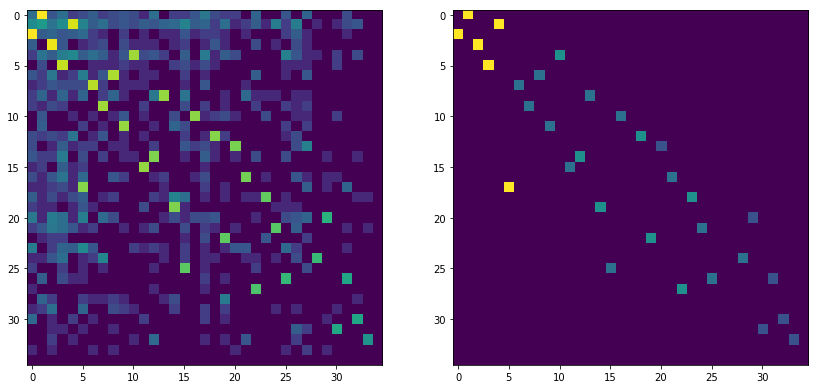

In [219]:
plot_group(gr, 1, o_gr , 0, s = 14)

In [35]:
def population_to_gr(population, spacers_num):
    graph = np.zeros((spacers_num, spacers_num))
    
    for chain in population:
        for p in ngrams(chain, 2):
            graph[p[0], p[1]] = 1
    
    return graph

In [36]:
def complete_population(population, shape):
    answ = np.ones(shape) * -1
    
    for i, chain in enumerate(population):
        answ[i, :len(chain)] = np.array(chain)
    return answ

In [229]:
def do_all(i):
    pp = generate_tree_population(35, 4)
    fpl, bpl = add_repeats(pp, 300)
    return amp_population(pp,fpl, bpl, mat, 35, cycles = 20)

In [230]:
from multiprocessing import Pool
import multiprocessing

In [233]:
pool = multiprocessing.Pool(4)

In [232]:
pool.close()

In [234]:
answ = pool.map(do_all, [0,1,2,3])

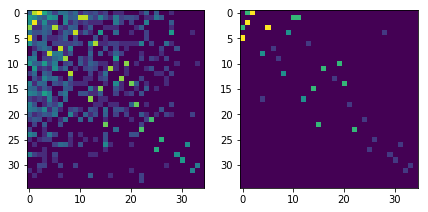

In [237]:
plot_group(answ[0][0], 1, answ[0][1], 0)

In [239]:
np.stack([x[0] for x in answ]).shape

(4, 35, 35)

In [370]:
params = {"N_POPULATONS" : 1000,
            "N_SPACERS" : 35,
            "N_CHAINS" : 12,
            "MAX_LEN" : 15,
            "SWITCH_PROB" : 0.15,
            "AMPLIFY_PROB"  :1,
            "STOP_PROB" : 0.1,
            "MAX_POPULATION_SIZE" : 3000}

SWITCH_PROB = params["SWITCH_PROB"]
AMPLIFY_PROB = params["AMPLIFY_PROB"]
STOP_PROB = params["STOP_PROB"]

synthetic_populations = np.zeros((params["N_POPULATONS"], params["N_CHAINS"], params["MAX_LEN"]))
amp_graphs = np.zeros((params["N_POPULATONS"], params["N_SPACERS"], params["N_SPACERS"]))
initial_graphs = np.zeros((params["N_POPULATONS"], params["N_SPACERS"], params["N_SPACERS"]))


for i in tqdm_notebook(range(params["N_POPULATONS"])):
#     p = generate_initial_population(generate_shift_diag_graph(params["N_SPACERS"]),
#                                     params["N_CHAINS"],
#                                     10,
#                                     max_len=params["MAX_LEN"])
    p = generate_tree_population(params["N_SPACERS"], 4, max_len=params["MAX_LEN"])
    p = reshuffle(p)
    #synthetic_populations[i] = complete_population(p, (params["N_CHAINS"], params["MAX_LEN"] ))

    amp_graphs[i],initial_graphs[i]= amp_population(p, params["N_SPACERS"], params["MAX_POPULATION_SIZE"], 50)
    #initial_graphs[i] = population_to_gr(p, params["N_SPACERS"])

A Jupyter Widget

In [372]:
#np.save("../../data/simulation/1000_35_like_true/populations", synthetic_populations)
np.save("../../data/simulation/1000_35_like_true/populations_gr", initial_graphs)
np.save("../../data/simulation/1000_35_like_true/amp_gr", amp_graphs)
json.dump(params, open("../../data/simulation/1000_35_like_true/params.json", 'w'))

In [76]:
params = {"N_POPULATONS" : 10000,
            "N_SPACERS" : 35,
            "N_CHAINS" : 12,
            "MAX_LEN" : 13,
            "SWITCH_PROB" : 0.05,
            "AMPLIFY_PROB"  :0.35,
            "STOP_PROB" : 0,
            "MAX_POPULATION_SIZE" : 10000}

SWITCH_PROB = params["SWITCH_PROB"]
AMPLIFY_PROB = params["AMPLIFY_PROB"]
STOP_PROB = params["STOP_PROB"]

synthetic_populations = np.zeros((params["N_POPULATONS"], params["N_CHAINS"], params["MAX_LEN"]))
amp_graphs = np.zeros((params["N_POPULATONS"], params["N_SPACERS"], params["N_SPACERS"]))
initial_graphs = np.zeros((params["N_POPULATONS"], params["N_SPACERS"], params["N_SPACERS"]))


for i in tqdm_notebook(range(params["N_POPULATONS"])):
    p = generate_initial_population(generate_shift_diag_graph(params["N_SPACERS"]),
                                    params["N_CHAINS"],
                                    10,
                                    max_len=params["MAX_LEN"])
    p = reshuffle(p, params["N_SPACERS"])
    synthetic_populations[i] = complete_population(p, (params["N_CHAINS"], params["MAX_LEN"] ))

    amp_graphs[i] = amp_population(p, params["N_SPACERS"], params["MAX_POPULATION_SIZE"], 20)
    initial_graphs[i] = population_to_gr(p, params["N_SPACERS"])

A Jupyter Widget

In [77]:
np.save("../../data/simulation/50sp_10k/populations", synthetic_populations)
np.save("../../data/simulation/50sp_10k/populations_gr", initial_graphs)
np.save("../../data/simulation/50sp_10k/amp_gr", amp_graphs)
json.dump(params, open("../../data/simulation/50sp_10k/params.json", 'w'))

# INV

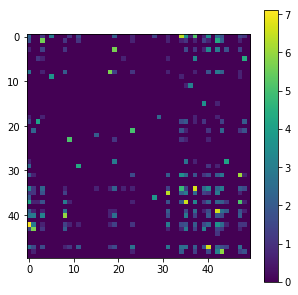

In [83]:
plot_gr(amp_graphs[0], s = 5, log = 1)

A Jupyter Widget

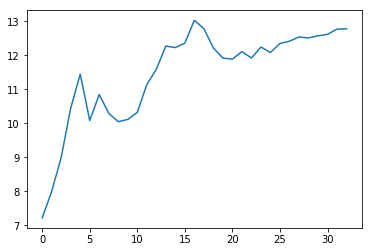

In [54]:
population_ratio = []

for i in tqdm_notebook(range(35)) :
    PCR_cycle(population_f, population_b)
    
    all_pairs = []
    for seq in population_f + [x[::-1] for x in population_b]:
        for x in ngrams(seq,2):
            all_pairs.append(x)
            
    cp_1, cp_2, cp_3 = 0,0,0
    for p in all_pairs:
        if p in pairs_1:
            cp_1+=1
        elif p in pairs_2:
            cp_2+=1
        else:
            cp_3+=1
            
#     c_1, c_2, c_3 = 0,0,0
#     for p in population_f:
#         for l in p:
#             if l in [0,1,2,3,4,5]:
#                 c_1+=1
#             elif l in [6,7,8,9]:
#                 c_2+=1
#             else:
#                 c_3+=1
    #print(len(population_f), c_1, c_2, c_3, c_1 / c_2)
    population_ratio.append(cp_1 / cp_2)
    
    #print(len(population_f))#, len(population_b))
    if len(population_f) >100000:
        break

all_ratios_plots.append(population_ratio)


for p_r in all_ratios_plots:
    plt.plot(p_r)
plt.show()



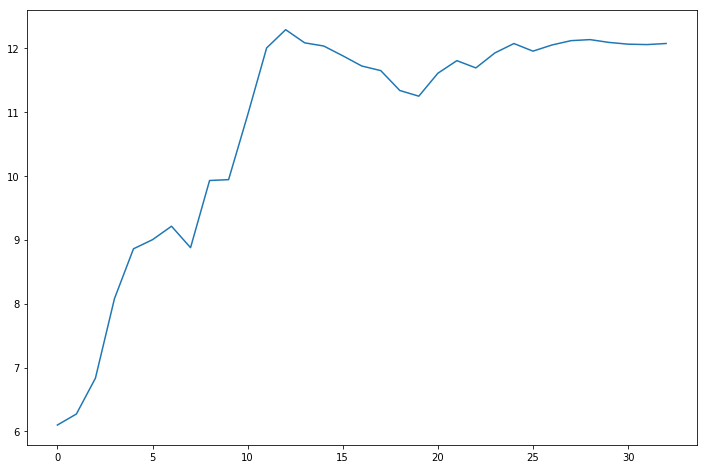

In [266]:
plt.figure(figsize=(12,8))

for p_r in all_ratios_plots:
    plt.plot(p_r)
plt.show()


In [167]:
c_1 / c_2

15.804110043089162

In [267]:
population = population_f + [x[::-1] for x in population_b]

In [134]:
all_pairs = []
for seq in population:
    for x in ngrams(seq,2):
        all_pairs.append(x)
len(all_pairs)

33222

In [268]:
graph = np.zeros((11,11))

for p in all_pairs:
    graph[p[0],p[1]] += 1

In [269]:
c_1, c_2, c_3 = 0,0,0
for p in all_pairs:
    if p in pairs_1:
        c_1+=1
    elif p in pairs_2:
        c_2+=1
    else:
        c_3+=1

In [270]:
print(c_1, c_2, c_3, c_1 / c_2)

224870 18631 22514 12.069668831517363


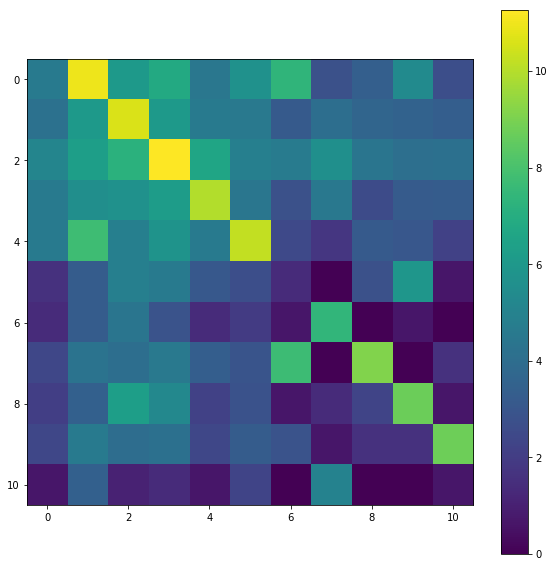

In [271]:
plot_gr(graph, log = 1)

In [589]:
c_2

3162

In [336]:
c_3

18988

In [480]:
pairs_1

<generator object ngrams at 0x7f7b6a570e60>

In [479]:
all_pairs[:30]

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (0, 6)]

In [283]:
ES3_b

[[16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [11, 7, 5, 2, 4],
 [11, 7, 5, 2, 4],
 [11, 7, 5, 2, 4],
 [11, 7, 5, 2, 4],
 [11, 7, 5, 2, 4],
 [34, 33, 32, 31, 28, 26, 27, 30, 25, 18, 19, 24],
 [29, 21, 23, 22, 20],
 [17, 15, 14],
 [13, 10, 9],
 [6, 3, 0],
 [11, 7],
 [7, 5, 2],
 [11, 7, 5, 2],
 [11, 7, 5, 2, 4],
 [32, 31],
 [29, 21],
 [16, 12, 17, 15, 14],
 [16, 12, 17, 15],
 [8, 6],
 [10, 9],
 [11, 7, 5, 2],
 [11, 7],
 [11, 7],
 [7, 5, 2],
 [12, 17, 15, 14],
 [14, 17, 15],
 [2, 4],
 [28, 26, 27, 30],
 [22, 20],
 [12, 17, 15],
 [16, 12],
 [12, 17],
 [6, 3],
 [11, 7, 5, 2],
 [11, 7, 5],
 [11, 7, 5, 2],
 [34, 33, 32, 31, 28, 26, 27, 30],
 [29, 21],
 [12, 17],
 [17, 15],
 [28, 26, 27, 30],
 [0, 1],
 [0, 1],
 [5, 2, 4],
 [5, 2, 4],
 [23, 22],
 [3, 0],
 [11, 7],
 [16, 12, 17, 15, 14, 13, 10, 9, 8

In [284]:
ES3_f

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 2, 5, 7, 11],
 [4, 2, 5, 7, 11],
 [4, 2, 5, 7, 11],
 [4, 2, 5, 7, 11],
 [24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [20, 22, 23, 21, 29],
 [13, 14, 15, 17, 12],
 [13, 14, 15, 17, 14],
 [1, 0, 3],
 [4, 2],
 [4, 2, 5],
 [5, 7, 11],
 [25, 30, 27, 26, 28],
 [20, 22],
 [1, 0],
 [1, 0, 3, 6, 8, 9, 10, 13],
 [1, 0],
 [1, 0],
 [4, 2, 5, 7],
 [4, 2, 5, 7],
 [4, 2, 5],
 [18, 25],
 [22, 23],
 [0, 3],
 [7, 11],
 [5, 7],
 [2, 5],
 [1, 15],
 [6, 8, 9, 10, 13],
 [3, 6],
 [1, 0, 3, 6, 8, 9],
 [1, 0, 3, 6],
 [4, 2, 5],
 [4, 2, 5, 7],
 [4, 2],
 [19, 18, 25, 30, 27],
 [22, 23],
 [14, 15, 17],
 [0, 3],
 [2, 5],
 [4, 2],
 [9, 10],
 [7, 11],
 [2, 5, 7],
 [4, 2],
 [30, 27],
 [20, 22],
 [1, 0],
 [3, 6],
 [4, 2, 5],
 [4, 2],
 [19, 18],
 [1

In [53]:
population=reshuffle(population, np.arange(10))

In [272]:
m = np.ones((3,3))

In [365]:
pp = generate_initial_population(5, 6, 5)
ppr = reshuffle(pp,5)
print(pp)
print(ppr)

[[0.         0.25       0.25       0.25       0.25      ]
 [0.         0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         0.5        0.5       ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         0.        ]]
5
5
4
[[0, 3, 4], [0, 3, 4], [1, 3, 4], [1, 3, 4], [0, 1, 3, 4], [0, 1, 3, 4]]
[[3, 1, 4], [3, 1, 4], [2, 1, 4], [2, 1, 4], [3, 2, 1, 4], [3, 2, 1, 4]]


In [684]:
population_f = [[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(5)] + \
        [[4, 2, 5, 7, 11] for i in range(5)] + \
        [[4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34]] + \
        [[1, 20, 22, 23, 21, 29]]
        
population_b = [x[::-1] for x in population_f]

In [390]:
pp = [[0,1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(5)] + \
        [[0,4, 2, 5, 7, 11] for i in range(5)] + \
        [[0,4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34]] + \
        [[0,1, 20, 22, 23, 21, 29]]

In [416]:
SWITCH_PROB = 0.1

In [417]:
def amp_population(population, max_sp_num, max_chains = 25000, max_epochs = 15):
    spacers_num = max([max(p) for p in population]) + 1
    
    population_f = [x for x in population]
    population_b = [[x[0]] + x[:0:-1] for x in population_f]

    print(population_f)
    print(population_b)
    epoch = 0
    
    while (len(population_f) + len(population_b) < max_chains) and epoch < max_epochs:
        PCR_cycle(population_f, population_b)
        epoch += 1
#         print(population_f)
#         print("\n")
#         print(population_b)
#         print("\n")
    
    full_population_amplified = [x[1:] for x in population_f] + [x[:1:-1] for x in population_b]
    
    all_pairs = []

    out_counts = dict(zip(np.arange(spacers_num), np.zeros(spacers_num)))
    in_counts = dict(zip(np.arange(spacers_num), np.zeros(spacers_num)))
    
    for seq in full_population_amplified:
        for x in ngrams(seq,2):
            all_pairs.append(x)
            out_counts[x[0]] += 1
            in_counts[x[1]] += 1
    
#     print(len(all_pairs))
#     print(len(full_population_amplified))

    #reorder_dict = rerank_dict(spacers_num, in_counts, out_counts)
    reorder_dict = dict(zip(np.arange(spacers_num), np.arange(spacers_num)))
    
    graph = np.zeros((max_sp_num, max_sp_num))
    for p in all_pairs:
        graph[reorder_dict[p[0]], reorder_dict[p[1]]] += 1
        
    original_graph = np.zeros((max_sp_num, max_sp_num))
    for p in population:
        for x, y in zip(p[1:], p[2:]):
            original_graph[reorder_dict[x], reorder_dict[y]] += 1

    return graph, original_graph

In [418]:
amp_g, t_g = amp_population(pp, 35, max_epochs=100)

[[0, 1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16], [0, 1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16], [0, 1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16], [0, 1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16], [0, 1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16], [0, 4, 2, 5, 7, 11], [0, 4, 2, 5, 7, 11], [0, 4, 2, 5, 7, 11], [0, 4, 2, 5, 7, 11], [0, 4, 2, 5, 7, 11], [0, 4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34], [0, 1, 20, 22, 23, 21, 29]]
[[0, 16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1], [0, 16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1], [0, 16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1], [0, 16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1], [0, 16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1], [0, 11, 7, 5, 2, 4], [0, 11, 7, 5, 2, 4], [0, 11, 7, 5, 2, 4], [0, 11, 7, 5, 2, 4], [0, 11, 7, 5, 2, 4], [0, 34, 33, 32, 31, 28, 26, 27, 30, 25, 18, 19, 24, 4], [0, 29, 21, 23, 22, 20, 1]]


In [419]:
pp

[[0, 1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [0, 1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [0, 1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [0, 1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [0, 1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [0, 4, 2, 5, 7, 11],
 [0, 4, 2, 5, 7, 11],
 [0, 4, 2, 5, 7, 11],
 [0, 4, 2, 5, 7, 11],
 [0, 4, 2, 5, 7, 11],
 [0, 4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [0, 1, 20, 22, 23, 21, 29]]

In [420]:
amp_g.max()

2048.0

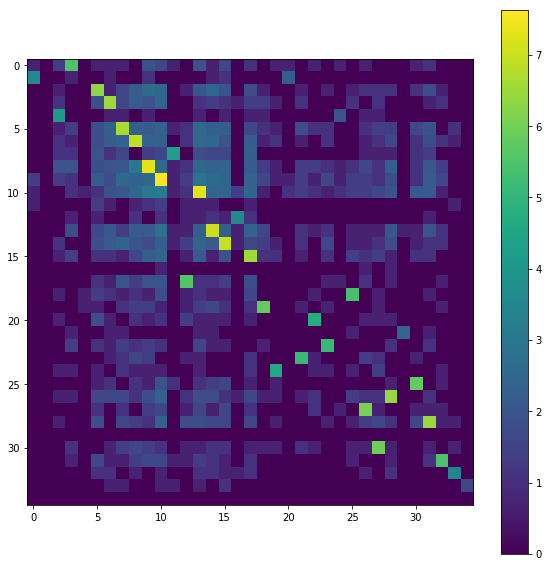

In [421]:
plot_gr(amp_g, log = 1)

## Clostrifdium

In [429]:
cgr = np.load("../../data/graphs/Sasha_22.npy")

In [435]:
import sys
sys.path.append("../h_module/")
sys.path.append("../h_module/")

In [437]:
import hamiltonian_path as hp

In [438]:
c = {}
hp.next_edge(cgr, c)

21

In [454]:
len(c[0].chain)

80

In [456]:
c[0].chain

[72,
 61,
 59,
 60,
 70,
 77,
 78,
 79,
 58,
 40,
 5,
 4,
 11,
 2,
 0,
 1,
 3,
 25,
 53,
 69,
 76,
 48,
 24,
 16,
 41,
 75,
 62,
 34,
 31,
 51,
 55,
 67,
 63,
 57,
 66,
 56,
 54,
 73,
 68,
 65,
 74,
 71,
 27,
 19,
 45,
 49,
 44,
 37,
 29,
 22,
 46,
 42,
 21,
 14,
 6,
 8,
 33,
 13,
 23,
 32,
 39,
 43,
 36,
 30,
 12,
 7,
 9,
 20,
 26,
 35,
 52,
 64,
 47,
 38,
 17,
 10,
 18,
 15,
 28,
 50]

In [440]:
weights = []
for a, b in zip(c[0].chain, c[0].chain[1:]):
    weights.append(cgr[a][b])

In [463]:
cassettes = []
cas = []
for a, b, w in zip(c[0].chain, c[0].chain[1:], weights):
    if w > 0:
        if len(cas) == 0:
            cas.append(a)
        cas.append(b)
    else:
        cassettes.append(cas)
        cas = []
    print(cas)
cassettes.append(cas)

[72, 61]
[72, 61, 59]
[72, 61, 59, 60]
[72, 61, 59, 60, 70]
[72, 61, 59, 60, 70, 77]
[72, 61, 59, 60, 70, 77, 78]
[72, 61, 59, 60, 70, 77, 78, 79]
[]
[58, 40]
[58, 40, 5]
[58, 40, 5, 4]
[58, 40, 5, 4, 11]
[58, 40, 5, 4, 11, 2]
[58, 40, 5, 4, 11, 2, 0]
[58, 40, 5, 4, 11, 2, 0, 1]
[58, 40, 5, 4, 11, 2, 0, 1, 3]
[58, 40, 5, 4, 11, 2, 0, 1, 3, 25]
[58, 40, 5, 4, 11, 2, 0, 1, 3, 25, 53]
[58, 40, 5, 4, 11, 2, 0, 1, 3, 25, 53, 69]
[58, 40, 5, 4, 11, 2, 0, 1, 3, 25, 53, 69, 76]
[]
[48, 24]
[48, 24, 16]
[48, 24, 16, 41]
[]
[75, 62]
[75, 62, 34]
[75, 62, 34, 31]
[75, 62, 34, 31, 51]
[75, 62, 34, 31, 51, 55]
[75, 62, 34, 31, 51, 55, 67]
[]
[63, 57]
[63, 57, 66]
[63, 57, 66, 56]
[63, 57, 66, 56, 54]
[63, 57, 66, 56, 54, 73]
[]
[68, 65]
[68, 65, 74]
[]
[71, 27]
[71, 27, 19]
[71, 27, 19, 45]
[71, 27, 19, 45, 49]
[71, 27, 19, 45, 49, 44]
[71, 27, 19, 45, 49, 44, 37]
[71, 27, 19, 45, 49, 44, 37, 29]
[71, 27, 19, 45, 49, 44, 37, 29, 22]
[71, 27, 19, 45, 49, 44, 37, 29, 22, 46]
[]
[42, 21]
[42, 21, 14]


In [464]:
cassettes

[[72, 61, 59, 60, 70, 77, 78, 79],
 [58, 40, 5, 4, 11, 2, 0, 1, 3, 25, 53, 69, 76],
 [48, 24, 16, 41],
 [75, 62, 34, 31, 51, 55, 67],
 [63, 57, 66, 56, 54, 73],
 [68, 65, 74],
 [71, 27, 19, 45, 49, 44, 37, 29, 22, 46],
 [42, 21, 14, 6, 8],
 [33,
  13,
  23,
  32,
  39,
  43,
  36,
  30,
  12,
  7,
  9,
  20,
  26,
  35,
  52,
  64,
  47,
  38,
  17,
  10,
  18,
  15,
  28,
  50]]

In [465]:
cassettes
pp = [[0] + x for x in cassettes]

In [466]:
cassettes

[[72, 61, 59, 60, 70, 77, 78, 79],
 [58, 40, 5, 4, 11, 2, 0, 1, 3, 25, 53, 69, 76],
 [48, 24, 16, 41],
 [75, 62, 34, 31, 51, 55, 67],
 [63, 57, 66, 56, 54, 73],
 [68, 65, 74],
 [71, 27, 19, 45, 49, 44, 37, 29, 22, 46],
 [42, 21, 14, 6, 8],
 [33,
  13,
  23,
  32,
  39,
  43,
  36,
  30,
  12,
  7,
  9,
  20,
  26,
  35,
  52,
  64,
  47,
  38,
  17,
  10,
  18,
  15,
  28,
  50]]

In [474]:
SWITCH_PROB = 0.005

In [475]:
agc, ogc = amp_population(pp, 82, max_epochs=100)

[[0, 72, 61, 59, 60, 70, 77, 78, 79], [0, 58, 40, 5, 4, 11, 2, 0, 1, 3, 25, 53, 69, 76], [0, 48, 24, 16, 41], [0, 75, 62, 34, 31, 51, 55, 67], [0, 63, 57, 66, 56, 54, 73], [0, 68, 65, 74], [0, 71, 27, 19, 45, 49, 44, 37, 29, 22, 46], [0, 42, 21, 14, 6, 8], [0, 33, 13, 23, 32, 39, 43, 36, 30, 12, 7, 9, 20, 26, 35, 52, 64, 47, 38, 17, 10, 18, 15, 28, 50]]
[[0, 79, 78, 77, 70, 60, 59, 61, 72], [0, 76, 69, 53, 25, 3, 1, 0, 2, 11, 4, 5, 40, 58], [0, 41, 16, 24, 48], [0, 67, 55, 51, 31, 34, 62, 75], [0, 73, 54, 56, 66, 57, 63], [0, 74, 65, 68], [0, 46, 22, 29, 37, 44, 49, 45, 19, 27, 71], [0, 8, 6, 14, 21, 42], [0, 50, 28, 15, 18, 10, 17, 38, 47, 64, 52, 35, 26, 20, 9, 7, 12, 30, 36, 43, 39, 32, 23, 13, 33]]


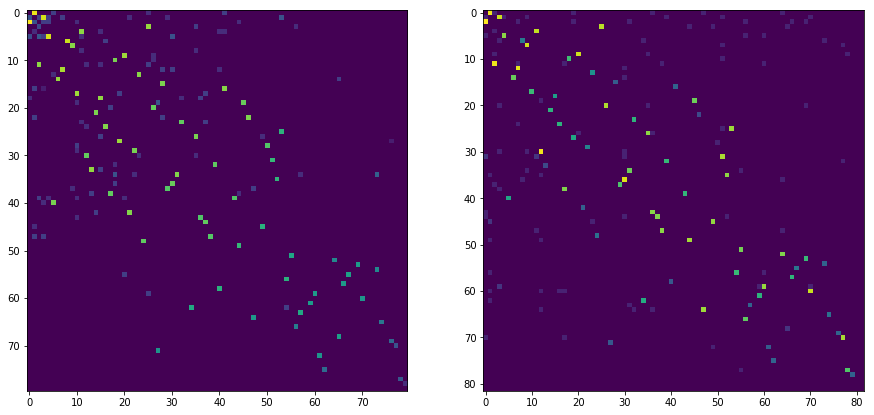

In [476]:
plot_group(cgr, 1, agc, 1, s = 15)

In [458]:
cgr[10, 18]

1031.0